* https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/15.object-detection.ipynb
* https://www.curiousily.com/posts/object-detection-on-custom-dataset-with-tensorflow-2-and-keras-using-python/

In [1]:
# !git clone https://github.com/fizyr/keras-retinanet.git
# %cd keras-retinanet/
# !pip install .
# !python setup.py build_ext --inplace

In [1]:
import urllib
import os
import csv
import cv2
import time
from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split

import sys 
sys.path.append('keras-retinanet')

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Data download

In [3]:
data_root_path = '../data/vehicle-number-plate-detection'
plates_df = pd.read_json(os.path.join(data_root_path, 'indian_number_plates.json'), lines=True)
plates_df.head(1)

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [7]:
# os.makedirs(os.path.join(data_root_path, "number_plates"), exist_ok=True)

In [9]:
dataset = dict()
dataset["image_name"] = list()
dataset["top_x"] = list()
dataset["top_y"] = list()
dataset["bottom_x"] = list()
dataset["bottom_y"] = list()
dataset["class_name"] = list()

counter = 0
for index, row in tqdm(plates_df.iterrows()):
    file_path = f'number_plates/licensed_car_{counter}.jpeg'
#     img = urllib.request.urlopen(row["content"])
#     img = Image.open(img)
#     img = img.convert('RGB')
#     img.save(os.path.join(data_root_path, file_path), "JPEG")
    
    dataset["image_name"].append(file_path)
    data = row["annotation"]

    width = data[0]["imageWidth"]
    height = data[0]["imageHeight"]

    dataset["top_x"].append(int(round(data[0]["points"][0]["x"] * width)))
    dataset["top_y"].append(int(round(data[0]["points"][0]["y"] * height)))
    dataset["bottom_x"].append(int(round(data[0]["points"][1]["x"] * width)))
    dataset["bottom_y"].append(
      int(round(data[0]["points"][1]["y"] * height))
    )
    dataset["class_name"].append("license_plate")

    counter += 1
print("Downloaded {} car images.".format(counter))


237it [00:00, 10788.47it/s]


Downloaded 237 car images.


In [2]:
df = pd.DataFrame(dataset)
df.head(1)

NameError: name 'dataset' is not defined

In [5]:
def show_image_objects(image_row):
    img_path = image_row.image_name
    box = [image_row.top_x, image_row.top_y, image_row.bottom_x, image_row.bottom_y]
    image = read_image_bgr(os.path.join(data_root_path, img_path))
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    draw_box(draw, box, color=(255, 255, 0))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

# show_image_objects(df.iloc[0])

## Preprocessing

In [11]:
ANNOTATIONS_FILE = 'annotations.csv'
VAL_ANNOTATIONS_FILE = 'val-annotations.csv'
CLASSES_FILE = 'classes.csv'

In [11]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

train_df.to_csv(os.path.join(data_root_path, ANNOTATIONS_FILE), index=False, header=None)
test_df.to_csv(os.path.join(data_root_path, VAL_ANNOTATIONS_FILE), index=False, header=None)

In [26]:
classes = set(df['class_name'].values)
with open(os.path.join(data_root_path, CLASSES_FILE), 'w') as f:
    for i, line in enumerate(sorted(classes)):
        f.write('{},{}\n'.format(line,i))

In [25]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'
train_df = pd.read_csv(os.path.join(data_root_path, ANNOTATIONS_FILE), names=['image_name', 'top_x', 'top_y', 'bottom_x', 'bottom_y', 'class_name'])
test_df = pd.read_csv(os.path.join(data_root_path,VAL_ANNOTATIONS_FILE), names=['image_name', 'top_x', 'top_y', 'bottom_x', 'bottom_y', 'class_name'])

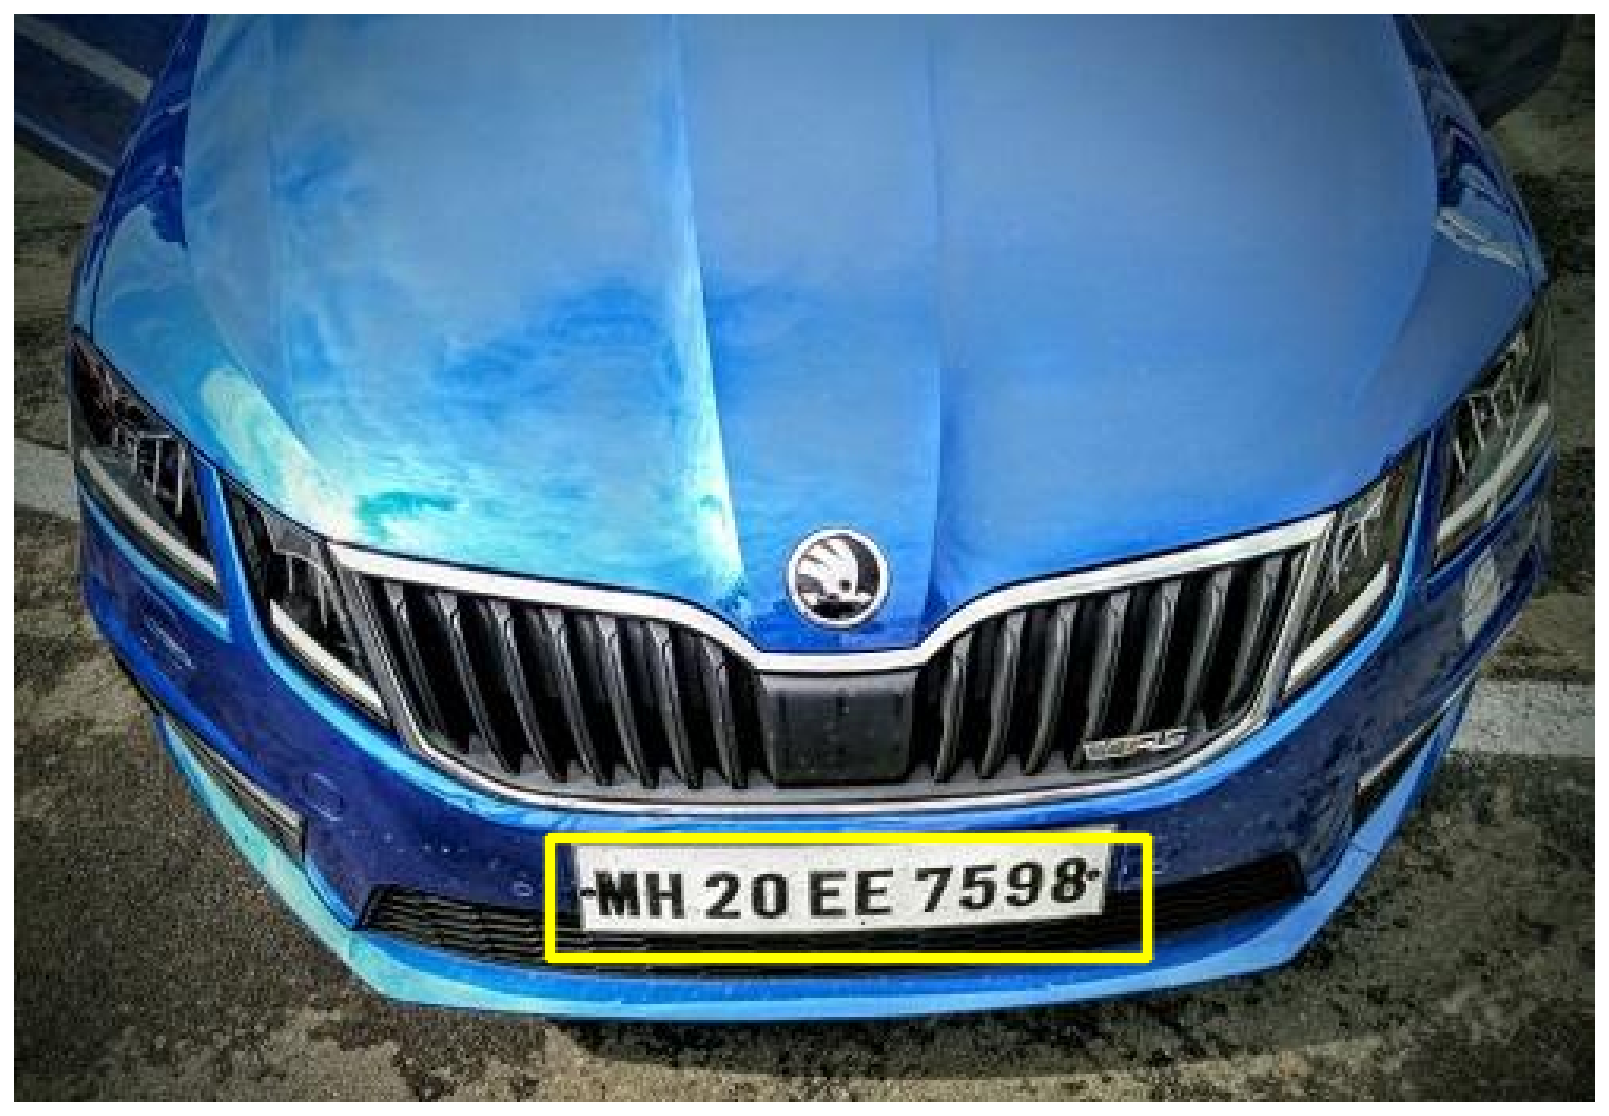

In [12]:
show_image_objects(train_df.iloc[0])

In [13]:
train_df.head(1)

,image_name,top_x,top_y,bottom_x,bottom_y,class_name
0,number_plates/licensed_car_183.jpeg,169,260,358,298,license_plate


## Train

In [3]:
# 아레 명령어 이거 씀.

python .\keras-retinanet\keras_retinanet\bin\train.py --imagenet-weights --backbone EfficientNetB0 --batch-size 2 --gpu 0  --epochs 30 --lr 0.0001 csv ..\data\vehicle-number-plate-detection\annotations.csv ..\data\vehicle-number-plate-detection\classes.csv --val-annotations ..\data\vehicle-number-plate-detection\val-annotations.csv